In [116]:
###############
# Import the data
###############

import pandas as pd

building_metadata = pd.read_csv('data/building_metadata.csv', dtype={'building_id': 'int16', 'primary_use': 'category'})
building_meter_readings = pd.read_csv('data/building_meter_readings.csv', parse_dates=['timestamp'], dtype={'meter': 'int16', 'meter_reading': 'float64', 'building_id': 'int16'})
weather_data = pd.read_csv('data/weather_data.csv', parse_dates=['timestamp'])

# Join all data
data = pd.merge(building_meter_readings, building_metadata, on='building_id')
data = pd.merge(data, weather_data, on=['site_id', 'timestamp'])

20125605
   building_id  meter  timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01            0.0        0   Education   
1            1      0 2016-01-01            0.0        0   Education   
2            2      0 2016-01-01            0.0        0   Education   
3            3      0 2016-01-01            0.0        0   Education   
4            4      0 2016-01-01            0.0        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         2720      2004.0          NaN             25.0             6.0   
2         5376      1991.0          NaN             25.0             6.0   
3        23685      2002.0          NaN             25.0             6.0   
4       116607      1975.0          NaN             25.0             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0      

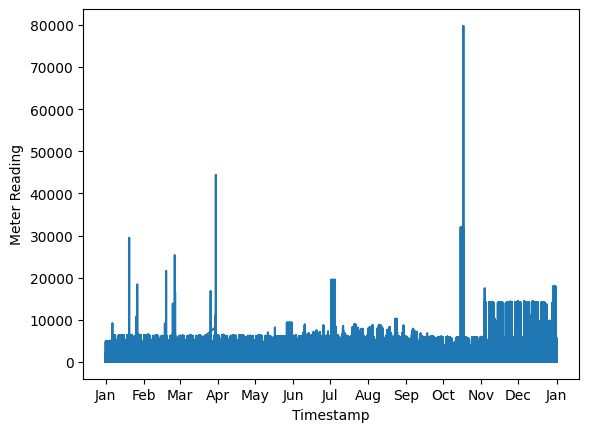

In [117]:
###############
# Data Exploration
###############
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

print(len(data))

print(data.head())

print(data['primary_use'].value_counts())
# plt.close()

# plot meter readings for building 0
building_0 = data[data['building_id'] == 0]
# plot only meter 0
building_0 = data[data['meter'] == 0]

xpoints = building_0['timestamp']
ypoints = building_0['meter_reading']


plt.plot(xpoints, ypoints)
plt.xlabel("Timestamp")
plt.ylabel("Meter Reading")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.show()



In [118]:
###############
# Data cleaning
###############

print("Rows before cleaning: " + str(len(data)))

# remove meter_reading 0 values
print("Removed " + str(len(data[data['meter_reading'] == 0])) + " rows with meter_reading = 0")
data = data[data['meter_reading'] != 0]

# remove rows with missing values
print("Removed " + str(data.isna().any(axis=1).sum()) + " rows with missing values")
data.dropna(inplace=True)

# Only keep electricity meter readings
print("Removed " + str(len(data['meter'] != 0)) + " rows with non-electricity meter readings")
data = data[data['meter'] == 0]
print("Rows remaining: " + str(len(data)))

#Convert timestamp into hour of day, day of week and month
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.dayofweek
data['month'] = data['timestamp'].dt.month
data.drop('timestamp', axis=1, inplace=True)

# encode categorical variables (one-hot encoding)
data = pd.get_dummies(data, columns=['primary_use'])

# Remove un-useful columns
data.drop(columns=['site_id', 'meter', 'building_id'], inplace=True)

# Small version of the dataset just for debugging
small_data = data.sample(n=1000, random_state=42)

Rows before cleaning: 20125605
Removed 1867887 rows with meter_reading = 0
Removed 17937883 rows with missing values
Removed 319835 rows with non-electricity meter readings
Rows remaining: 319835


In [119]:
##################
# Model selection
##################

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def run_model(model):
    y = data['meter_reading']
    x = data.drop(columns=['meter_reading'], inplace=False)

    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Train the model
    regressor = model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)

    # Make predictions on the training set
    y_pred_train = model.predict(x_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f'Mean Squared Error test: {mse_test}')
    print(f'Mean Squared Error train: {mse_train}')

    # Plot actual vs. predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Energy Usage')
    plt.ylabel('Predicted Energy Usage')
    plt.title('Actual vs. Predicted Energy Usage')
    plt.show()

    return mse_train, mse_test



# Grouped Bar Chart for both training and validation data
def plot_results(x_label, y_label, plot_title, results):
    # Set size of plot
    plt.figure(figsize=(12,6))
    labels = [result["name"] for result in results]
    X_axis = np.arange(len(labels))
    ax = plt.gca()

    plt.bar(X_axis-0.2, list(map(lambda x: x['train_mse'], results)) , 0.4, color='blue', label='Training')
    plt.bar(X_axis+0.2, list(map(lambda x: x['test_mse'], results)), 0.4, color='red', label='Validation')
    plt.title(plot_title, fontsize=30)
    plt.xticks(X_axis, labels)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


settings = [('Linear Regression', LinearRegression()), ('Decision Tree', DecisionTreeRegressor()), ('Random Forest', RandomForestRegressor()), ('Gradient Boosting', GradientBoostingRegressor())]

# settings = []

results = []
for name, model in settings:
    result = run_model(model)
    print(name + " results: " + str(result))
    results.append({'name': name, 'train_mse': result[0], 'test_mse': result[1]})
    plot_results(name, "Mean Squared Error", name, results)

for i in range(len(results)):
    print(results[i]['name'] + ": " + "train_mse " + str(result[i]['train_mse']) +  str(results[i]['test_mse']))


Mean Squared Error test: 1289.2471927607928
Mean Squared Error train: 1180.3535459058853


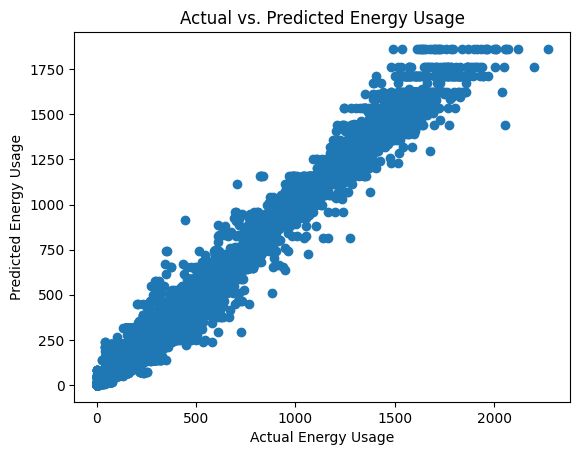

square_feet: 0.14442463144674225
year_built: 0.20070094471409056
floor_count: 0.6343693456202949
air_temperature: 0.0005318032201043515
cloud_coverage: 2.7487343670913975e-05
dew_temperature: 0.0011846412616935277
precip_depth_1_hr: 0.0
sea_level_pressure: 0.00032090609962177625
wind_direction: 8.174498629307807e-05
wind_speed: 0.0003091870583308636
hour: 0.011087801928171903
day: 0.0013384441508852165
month: 0.0026210038308635574
primary_use_Education: 4.7624477168998884e-05
primary_use_Entertainment/public assembly: 0.0001978002851014807
primary_use_Food sales and service: 0.0
primary_use_Healthcare: 0.0
primary_use_Lodging/residential: 0.0006713143058189983
primary_use_Manufacturing/industrial: 0.0
primary_use_Office: 0.0
primary_use_Other: 0.0
primary_use_Parking: 1.422629457928768e-05
primary_use_Public services: 0.002071092976568104
primary_use_Religious worship: 0.0
primary_use_Retail: 0.0
primary_use_Services: 0.0
primary_use_Technology/science: 0.0
primary_use_Utility: 0.0
pri

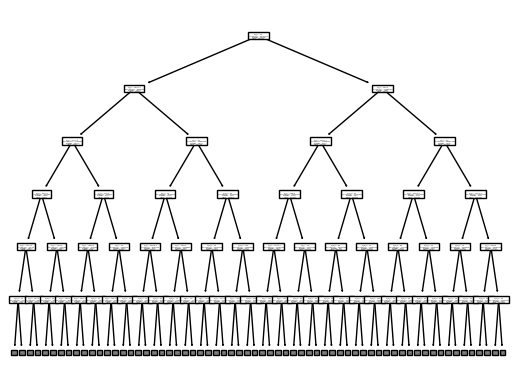

In [120]:
##################
# Feature Selection
##################

model = DecisionTreeRegressor(max_depth=10)
y = data['meter_reading']
x = data.drop(columns=['meter_reading'], inplace=False)
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train the model
regressor = model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Make predictions on the training set
y_pred_train = model.predict(x_train)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'Mean Squared Error test: {mse_test}')
print(f'Mean Squared Error train: {mse_train}')

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Energy Usage')
plt.ylabel('Predicted Energy Usage')
plt.title('Actual vs. Predicted Energy Usage')
plt.show()

# Plot the tree
tree.plot_tree(regressor, max_depth=5)

# Feature importance
feature_importance = model.tree_.compute_feature_importances()
for i in range(len(feature_importance)):
    print(x.columns[i] + ": " + str(feature_importance[i]))


Mean Squared Error test: 1290.3605670393185
Mean Squared Error train: 1180.353545905885


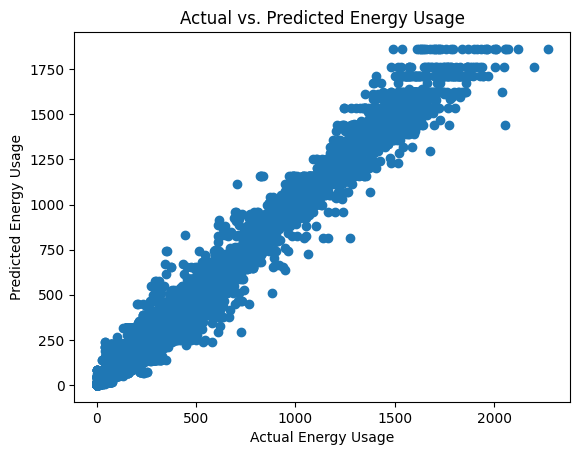

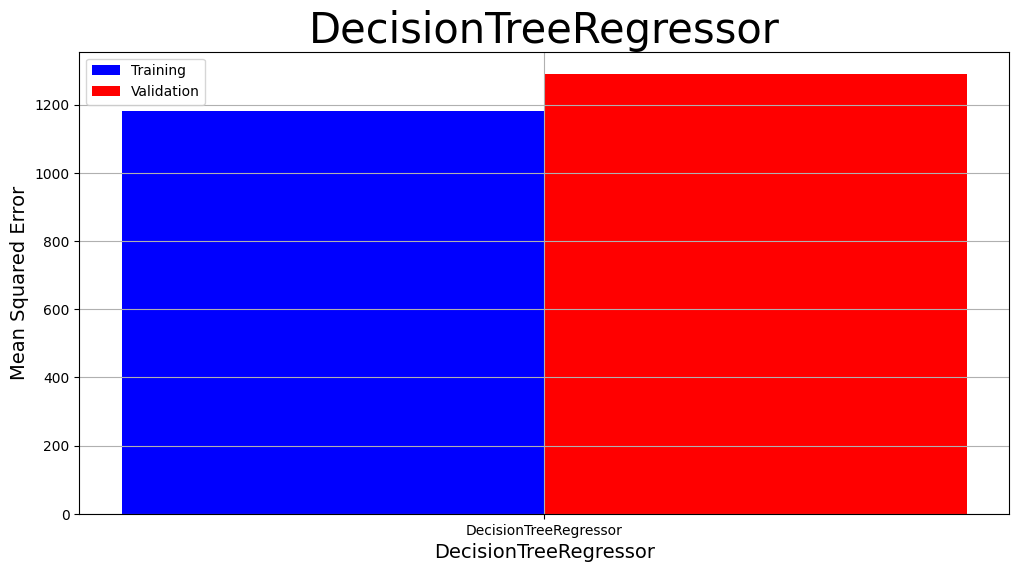

InvalidParameterError: The 'cv' parameter of GridSearchCV must be an int in the range [2, inf), an object implementing 'split' and 'get_n_splits', an iterable or None. Got 1 instead.

In [122]:
##################
# Hyperparameter tuning
##################
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor(max_depth=10)

result_without_tuning = run_model(model)
plot_results('DecisionTreeRegressor', "Mean Squared Error", 'DecisionTreeRegressor', [{'name': 'DecisionTreeRegressor', 'train_mse': result_without_tuning[0], 'test_mse': result_without_tuning[1]}])

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

grid_search=GridSearchCV(model,param_grid=parameters,scoring='neg_mean_squared_error',cv=1,verbose=3)
grid_search.fit(x, y)

print(grid_search.best_score_)
print(grid_search.best_params_)
